# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Ivan Yovchev"
NAME2 = "Balint Hompot"
NAME3 = "Davide Barbieri"
EMAIL = "yovchev23@gmail.com"
EMAIL2 = "balint.hompot@student.uva.nl"
EMAIL3 = "davidebarbieri97@gmail.com"

# Lab 2: Classification

### Machine Learning 1, September/October 2019

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

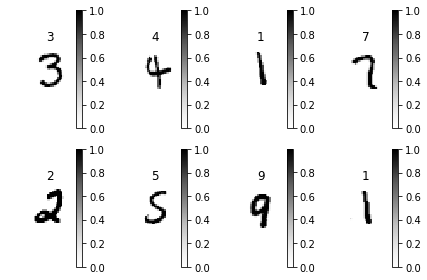

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



$$\frac{\partial logZ}{\partial Z}=\frac{1}{Z}$$
If we consider a as the input to the softmax, so $$q = e^{a}$$

$$\frac{\partial Z}{\partial log q_{j}} = \frac{\partial \Sigma_{K}e^{a_{k}}}{\partial a_{j}} = e^{a_{j}} = q_{j}$$
So the product of the second part of the partial derivative:
$$\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} = \frac{q_j}{Z}$$
(Which is equal to the softmax output for class j.)
Plugging this into the original formula we get:

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{q_j}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= 0 - \frac{q_j}{Z}
\end{align}


Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

Note that we defined $q_{j} = e^{w_{j}^{T} x + b}$, so $log(q_{j}) = w_{j}^{T} x + b$. If we take the derivative of this w.r.t. $w_{ij}$, we get simply $x_i$.
Plugging this into the full gradient equation, we get:
$$\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
x_i$$

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    
    # First compute the activations
    activation = np.exp(np.dot(x,w) + b);
    
    # The normalized activations
    activation_normalized = activation / sum(activation)
    
    # log of the softmax
    logp = np.log(activation_normalized)
    
    # make onehot out of targer
    t_onehot = np.zeros((activation_normalized.shape))
    t_onehot[:,t] = 1
    
    # Gradient w.r.t bias
    dL_db = t_onehot - activation_normalized
    
    # Gradient w.r.t. weights
    dL_dw = np.dot(np.transpose(x),dL_db)

    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [7]:
# This function is similar to the one above, but it only calculates error, no gradients
# For validation/test sets
def logreg_error(x, t, w, b):
    
    # First compute the activations
    activation = np.exp(np.dot(x,w) + b);
    
    # The normalized activations
    activation_normalized = activation / sum(activation)
    
    # log of the softmax
    logp = np.log(activation_normalized)
    

    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    return logp[:,t].squeeze()


In [8]:
# Hidden tests for efficiency

In [9]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [10]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 5.72736950555e-07
Finite difference error grad_b: 3.18414699521e-08


In [11]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-4`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [12]:
def sgd_iter(x_train, t_train, W, b):
    eta = 0.0001
    # iterating over instances
    # SGD: we update one by one
    epoch_logPs = 0.0
    
    data = list(zip(x_train, t_train))
    np.random.shuffle(data)
    
    for x,t in data:
        # reshaping input for the function
        x_train_current = np.reshape(x, (1, x.size))
        # getting the gradients for training
        logp_train, dW, db = logreg_gradient(x_train_current, t, W, b)
        epoch_logPs += logp_train
        W += eta * dW
        b += eta * db
    return epoch_logPs/size(x_train, 0), W, b

In [13]:
def validation_iter(x_valid, t_valid, W, b):
    # this function is similar to the sgd iter, but does not calculate gradients, and does not update weights
    # Only for calculating errors on the validation/test set
    # iterating over instances
    epoch_logPs = 0.0

    for index in range(0, len(x_valid)):
        # reshaping input for the function
        x_valid_current = np.reshape(x_valid[index], (1, x_valid[index].size))
        # getting the error of validation
        logp_valid = logreg_error(x_valid_current, t_valid[index], W, b)
        epoch_logPs += logp_valid

    return epoch_logPs/size(x_valid, 0)

In [14]:
# Hidden tests for efficiency

In [15]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

epoch  0
	avg training log(p):	 -1.21658440888
	avg validation log(p):	 -0.798080955003
epoch  1
	avg training log(p):	 -0.681830060554
	avg validation log(p):	 -0.611684188309
epoch  2
	avg training log(p):	 -0.561777599301
	avg validation log(p):	 -0.536633334257
epoch  3
	avg training log(p):	 -0.504027161803
	avg validation log(p):	 -0.493981292206
epoch  4
	avg training log(p):	 -0.468698317502
	avg validation log(p):	 -0.466177465788
epoch  5
	avg training log(p):	 -0.44429780832
	avg validation log(p):	 -0.445939370401
epoch  6
	avg training log(p):	 -0.426215460972
	avg validation log(p):	 -0.430798582268
epoch  7
	avg training log(p):	 -0.412122292849
	avg validation log(p):	 -0.418399590168
epoch  8
	avg training log(p):	 -0.400683243029
	avg validation log(p):	 -0.408597479361
epoch  9
	avg training log(p):	 -0.39118992472
	avg validation log(p):	 -0.400186373187
epoch  10
	avg training log(p):	 -0.383147558177
	avg validation log(p):	 -0.392901462509
epoch  11
	avg training

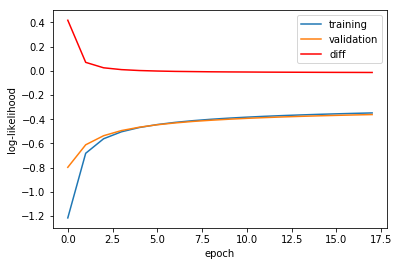

In [16]:

def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    epoch_likelihoods = []
    test_likelihoods = []
    stopping_likelihood_crit = -0.35
    for epoch in range(0, 100):
        
        print("epoch ", epoch)
        
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
           
        logp_test = validation_iter(x_valid, t_valid, w, b)

        epoch_likelihoods.append(logp_train)
        test_likelihoods.append(logp_test)
        print("\tavg training log(p):\t", logp_train)
        print("\tavg validation log(p):\t", logp_test)
        if logp_train>stopping_likelihood_crit:
            break
            
    plt.plot(epoch_likelihoods, label = "training")
    plt.plot(test_likelihoods, label = "validation")
    plt.plot(np.array(test_likelihoods)-np.array(epoch_likelihoods), label="diff", color="red")

    plt.ylabel('log-likelihood')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    return w, b
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [17]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


In [18]:
def plot_weights(data, num_cols, targets=None, shape=(28,28)):
    ### this is a modification of plot_digits
    ### only the tight layout was removed for better visisbility
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.show()

(784, 10)


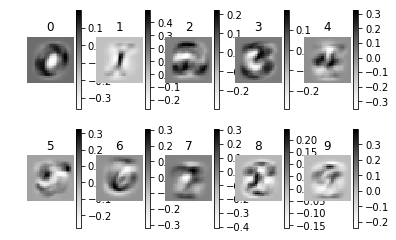

In [19]:
# YOUR CODE HERE
print(w.shape)
plot_weights(np.transpose(w), num_cols=5, targets = [0,1,2,3,4,5,6,7,8,9])

**Describe in less than 100 words why these weights minimize the loss**
As expected, the regions that are specific and highly descriptive for a digit get strong positive weight to help with classification, while the regions that are present in other digits but not in the one in focus get highly negative to help with discrimination. E.g. for classifying a 0, we are looking for a circular shape, so that is positive, but we also need to make sure, that there is nothing in the middle, otherwise it could be 6 or 8, so that is highly negative.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


In [20]:
def plot_digits_double(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title("{:.2f}".format(math.floor(targets[i] * 100)/100.0))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [21]:
def plot_eight(x, t, w, b, reverse=True):
    # compute activation
    activation = np.exp(np.dot(x,w) + b);

    asd = sum(activation,axis=1)

    # compute softmax
    softmax = activation / sum(activation,axis=1)[:,None]

    # indecies of highest activations per row
    predicted_class = np.argmax(softmax, axis=1)

    # compare to targets
    wrong_class = t_valid - predicted_class

    # indecies of wrong classifications
    idx_wrong_class = np.where(wrong_class != 0)

    # convert to dict
    dict_softmax = dict(enumerate(softmax))

    #  delete wrong classification
    for i in np.asarray(idx_wrong_class).squeeze():
        del dict_softmax[i]

    # sort
    dict_sorted = sorted(dict_softmax.items(), key = lambda x : np.amax(x[1]), reverse=reverse)

    # get first 8 instances
    data = np.empty([8,784])
    target_data = []
    for i in range(0,8):
        data[i] = x_valid[dict_sorted[i][0]]
        target_data.append(np.amax(dict_sorted[i][1]))

    # plot 
    plot_digits_double(data, 4,target_data)

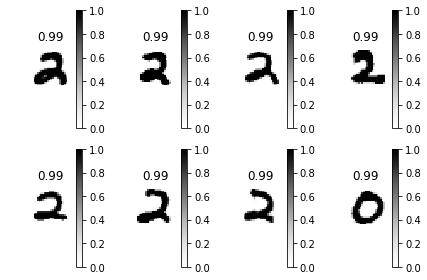

In [22]:
plot_eight(x_valid, t_valid, w, b, True)

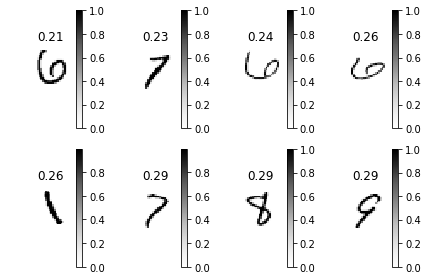

In [23]:
plot_eight(x_valid, t_valid, w, b, False)

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

It can be seen that the digits with the lowest probability (thus that the model relates the least to their true class) are not as legible and close to their prototypical counterparts (how in general its digit is written), while the ones that are strongly related to their true class are similar between themselves (and the prototypical version of the digits), which is probably because most of the 2s and 0s in the data-set are written in a similar manner. Thus the results do make sense.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

$\nabla_\mathbf{b}\mathbf{\mathcal{L^{(n)}}}$ can be calculated the same way as for the logistic regression:

$$
    \frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
    = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
    \frac{\partial \log q_j}{\partial b_j}
    = \delta^q_j
    \cdot 1
    = \delta^q_j
$$

In a similar way we did for the logistic regression, given that $\log q_j = \bw_j^T \bh + b_j$ we can calculate $\nabla_\mathbf{w_j}\mathbf{\mathcal{L^{(n)}}}$:

$$
    \frac{\partial \mathcal{L}^{(n)}}{\partial w_{ji}} = \frac{\partial \mathcal{L}^{(n)}}{\partial log q_{j}}\frac{\partial log q_{j}}{\partial w_{ji}} = \delta^q_j h_i
$$

Next we have $\delta^h_j$:

$$
    \delta_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j} = \sum_i \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_i} \frac{\partial \log q_i}{\partial h_j} = \sum_i \delta^q_i w_{ij}
$$

thus we can vectorize $\delta^h$ as:

$$
\delta^h = W\delta^q
$$

For $\frac{\partial \mathcal{L}^{(n)}}{\partial a_j}$ the derivation is the following:

$$
    \frac{\partial \mathcal{L}^{(n)}}{\partial a_j} = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}\frac{\partial h_j}{\partial a_j} = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}\frac{\partial \sigma(\bv_j^T \bx + a_j)}{\partial (\bv_j^T \bx + a_j)}\frac{\partial (\bv_j^T \bx + a_j)}{\partial a_j} = \delta^h_j \cdot \sigma(\bv_j^T \bx + a_j)  \left(1 - \sigma(\bv_j^T \bx + a_j)\right) = \delta^h_j \cdot h_j  \left(1 - h_j\right)
$$

that vectorize yields 

$$
 \frac{\partial \mathcal{L}^{(n)}}{\partial a} =  \delta^h \circ \left( h  \circ \left(1 - h\right)\right)
$$

And finally we have $\frac{\partial \mathcal{L}^{(n)}}{\partial v_{ji}}$:
$$
    \frac{\partial \mathcal{L}^{(n)}}{\partial \bv_{ji}} = \frac{\partial \mathcal{L}^{(n)}}{\partial h_{j}}\frac{\partial h_j}{\partial \bv_{ji}} = \frac{\partial \mathcal{L}^{(n)}}{\partial h_{j}}\frac{\partial \sigma(\bv_j^T \bx + a_j)}{\partial (\bv_j^T \bx + a_j)}\frac{\partial (\bv_j^T \bx + a_j)}{\partial \bv_{ji}} = \delta^h_j\cdot h_j\left(1 - h_j\right)\cdot x_i
$$

which vectorized finally gives

$$
 \frac{\partial \mathcal{L}^{(n)}}{\partial \bv} = x\cdot \left( \delta^h \circ  h  \circ \left(1 - h\right)\right)^{\text{T}}
$$

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

Since $\text{argmax}_{\theta} p(\theta\mid X,T) = \text{argmax}_{\theta} \frac{p(X,T\mid\theta )p(\theta)}{p(X,T)} =  \text{argmax}_{\theta} \text{log} p(X,T\mid\theta ) + \text{log}p(\theta) $ where $p(X,T\mid\theta )$, $p(\theta )$, and $p(\theta\mid X,T)$ are respectively the likelihood, prior, and posterior, we see that to do MAP we simply need to add a term which, if it's a gaussian with mean zero, it's simply a quadratic sum of the weights.

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [31]:
# ACTIVATION FUNCTIONS
class Sigmoid():
    
    @staticmethod
    def __call__(x):
        return 1. / (1 + np.exp(-x))
    
    @staticmethod
    def deriv(y):
        return y*(1-y)

class MLP_Model:
    
    def __init__(self, in_size, hid_size, out_size, alpha, delta):
        
        self.V = np.random.rand(in_size,hid_size)*2-1
        self.a = np.random.rand(hid_size)*2-1
        self.W = np.random.rand(hid_size,out_size)*2-1
        self.b = np.random.rand(out_size)*2-1
        
        self.alpha = alpha
        
        self.delta = delta

    def __call__(self, x, t=None, log_p=None, h=None):
        
        if t!=None:
            if all(log_p!=None) :
                return self.backward_pass(x, t, log_p, h)
            else:
                log_p, h = self(x)
                self(x, t, log_p, h)
                return log_p
            
        return self.forward_pass(x)
        
    def forward_pass(self, x):

        # forward propagate to hidden layer
        # and compute sigmoid activation
        h = self.delta(np.dot(np.transpose(self.V), x) + self.a)

        # forward propagate to output layer
        log_q = np.dot(np.transpose(self.W), h) + self.b

        # compute log_Z using log-sum-exp trick
        max_x = np.amax(log_q)
        log_Z = max_x + np.log(np.sum(np.exp(log_q - max_x)))

        # compute log_p
        log_p = log_q - log_Z

        return log_p, h

    def backward_pass(self, x, t, log_p, h):

        # compute values for delta^q
        # where grad_b = delta^q
        grad_b = -np.exp(log_p)

        # all values are where j != t are delta^q_j = -q/Z
        # excpet when j == t then delta^q_j = -q/Z + 1
        grad_b[t] += 1

        # dot product of two vectors which dont
        # a second dimension resulting in a matrix
        grad_W = np.outer(h,grad_b)

        delta_h = np.dot(self.W, grad_b)

        grad_a = delta_h * self.delta.deriv(h)

        grad_V = np.outer(x, grad_a)
        
        # Update parameters
        
        self.b += self.alpha * grad_b
        self.W += self.alpha * grad_W
        self.a += self.alpha * grad_a
        self.V += self.alpha * grad_V

        return grad_b, grad_W, grad_a, grad_V

def sgd_epoch(x_train, t_train, x_valid, t_valid, model):
    
    log_p_train = 0.0;
    log_p_valid = 0.0;
    
    # randomize inputs for SGD
    data = list(zip(x_train, t_train))
    np.random.shuffle(data)
    #x_train[:], t_train[:] = zip(*data)
    
    # train on every data point
    for x,t in data:
        # forward propagate to calculate prediction
        log_p = model(x, t)
        
        # keep track of all log_p to average them
        log_p_train += log_p[t]
        
    # validate
    for x,t in zip(x_valid, t_valid):
        
        # do only forward pass
        log_p, _ = model(x)
        
        # keep track of all log_p to average them
        log_p_valid += log_p[t]
    
    return log_p_train / size(x_train, 0),log_p_valid / size(x_valid, 0)



In [25]:
# Hidden tests for efficiency

In [26]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

def test_model(alpha, delta, num_hid=20, num_epochs=10, do_plot=None):
    
    # Store log p per epoc
    l_log_p_train = []
    l_log_p_valid = []
    
    # Create a model with given paramters
    model = MLP_Model(x_train.shape[1], num_hid, 10, alpha, delta)
    
    # Run epochs
    for i in range(num_epochs):
        
        print("epoch: ", i)
        
        log_p_train, log_p_valid = sgd_epoch(x_train, t_train, x_valid, t_valid, model)
        
        print("\tLog_p train: ", log_p_train)
        print("\tLog_p valid: ", log_p_valid)
        
        l_log_p_train.append(log_p_train)
        l_log_p_valid.append(log_p_valid)
        
    # Plot results if requested
    if do_plot:
        plt.plot(l_log_p_train, label=do_plot+" train")
        plt.plot(l_log_p_valid, label=do_plot+" valid")
        
    return log_p_train, log_p_valid, model
        
        
def swipe_alpha(alphas, delta, num_hid=20, num_epochs=10):
    
    max_log_p = None
    best_alpha = None
    best_model = None
    
    for alpha in alphas:
        print("\nUSING ALPHA =", alpha, "\n")
        log_p_train, log_p_valid, model = test_model(alpha, delta, num_hid, num_epochs, "lr="+str(alpha))
        
        if not best_alpha or log_p_valid>max_log_p:
            max_log_p = log_p_valid
            best_alpha = alpha
            best_model = model
        
    plt.legend()
    plt.show()
    
    return best_alpha, max_log_p, best_model


USING ALPHA = 0.01 

epoch:  0
	Log_p train:  -0.6415766021
	Log_p valid:  -0.394759052385
epoch:  1
	Log_p train:  -0.343715560442
	Log_p valid:  -0.318821833277
epoch:  2
	Log_p train:  -0.285943989444
	Log_p valid:  -0.279868084504
epoch:  3
	Log_p train:  -0.252492994245
	Log_p valid:  -0.263402353963
epoch:  4
	Log_p train:  -0.229458653273
	Log_p valid:  -0.244326203467
epoch:  5
	Log_p train:  -0.212776911577
	Log_p valid:  -0.233385997777
epoch:  6
	Log_p train:  -0.199696394856
	Log_p valid:  -0.222056918503
epoch:  7
	Log_p train:  -0.188976286413
	Log_p valid:  -0.219357788788
epoch:  8
	Log_p train:  -0.179714910787
	Log_p valid:  -0.215500837739
epoch:  9
	Log_p train:  -0.172594177598
	Log_p valid:  -0.205676025037

USING ALPHA = 0.001 

epoch:  0
	Log_p train:  -1.48708166845
	Log_p valid:  -1.02017223553
epoch:  1
	Log_p train:  -0.841775908915
	Log_p valid:  -0.727381953629
epoch:  2
	Log_p train:  -0.646709292415
	Log_p valid:  -0.597649562854
epoch:  3
	Log_p train:

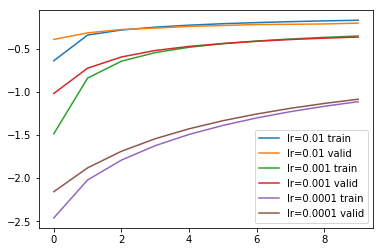

Best Alpha:  0.01 	with log(p) =  -0.205676025037


In [27]:
num_epochs = 10
num_hid = 20

best_alpha, max_log_p, best_model = swipe_alpha([1e-2, 1e-3, 1e-4], Sigmoid(), num_epochs=num_epochs, num_hid=num_hid)

print("Best Alpha: ", best_alpha, "\twith log(p) = ", max_log_p)

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

It can be seen that the model improves at each iteration. Moreover, the learning curve is the steepest in the early epochs, which means that the model is converging faster to the local maxima at the beginning, and as it gets closer to it learning slows down. It is clearly seen that the learning curves from the different learning rates approach each other, and thus converge to solutions with similar performances. However, lower learning rates yield a slower learning process.

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

Weights for the first layer of the best model after training


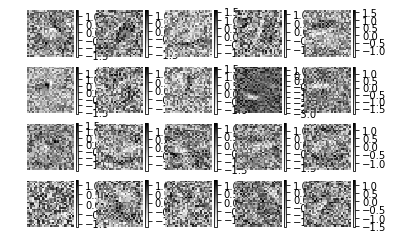

Weights for the best model at epoch  0


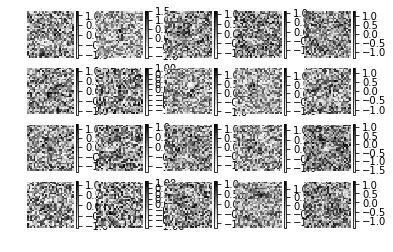

Weights for the best model at epoch  4


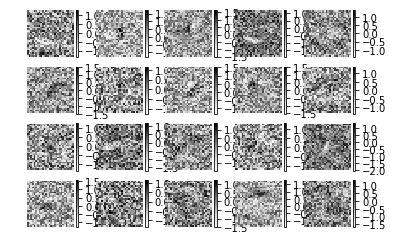

Weights for the best model at epoch  9


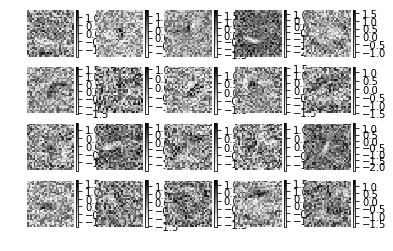

In [28]:
print("Weights for the first layer of the best model after training")
plot_weights(np.transpose(best_model.V), 5)

# epochs at which to show the weights
weight_plots = [0, 4, 9]

# Create a model with best paramters
model = MLP_Model(x_train.shape[1], num_hid, 10, best_alpha, Sigmoid())

# Run epochs
for epoch in range(num_epochs):

    sgd_epoch(x_train, t_train, x_valid, t_valid, model)

    if epoch in weight_plots:
        print("Weights for the best model at epoch ", epoch)
        plot_weights(np.transpose(model.V), 5)

As we know the first layer of the MLP learns features by itself (as opposed to having basis functions which are predefined), therefore the machine learns it's own features which usually are not human readable (as seen in the plots). In fact Neural Nets are famously known to be black boxes. However, we can see some vague patterns more evident in the last epochs, representing archs.

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

The hyperbolic function is defined as follows:

$$
    tanh(x) = \frac{sinh(x)}{cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

The derivative is then given by:

$$
    \frac{\partial}{\partial x}tanh(x) = \frac{(e^x + e^{-x})(e^x + e^{-x}) - (e^x - e^{-x})(e^x - e^{-x})}{(e^x + e^{-x})^2} = 1 - \frac{(e^x - e^{-x})^2}{(e^x + e^{-x})^2} = 1 - tanh^2(x)
$$

The ReLU function is defined as follows:

$$
    ReLU= f(x) = max(0, x)
$$

which translates to

$$
    ReLU = f(x) = \begin{cases} 
      0 & x\leq 0 \\
      x & x > 0 
   \end{cases}
$$

In the first case $f'(x) = 0$ since the derivative of zero is still zero. In the second case $f'(x) = x' = 1$.

In compact form the derivative is given by:

$$
    f'(x) = \begin{cases} 
      0 & x < 0 \\
      1 & x > 0 
   \end{cases}
$$

This means that the derivative is not defined at $x = 0$.

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

First, we want to be our activastion functions to be non-linear. The first layers of a neural network are meant to make it learn it's own basis functions, so that the engineer doesn't have to pick them. Therefore, non-linear activation functions helps the network to have a non-linear behavior. Most importantly however, a fast convergence is also important, which depends on the activation function's derivative. In other words, an activation function should have a derivative that allows the network to take into account out-liars as well as exact mathces (unlike with the step function for instance). 


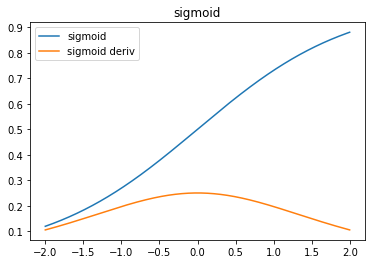

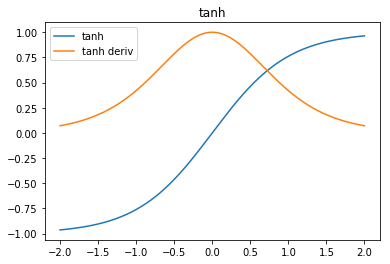

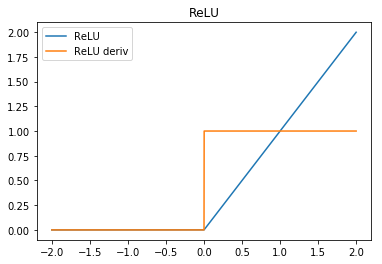

In [29]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

class Tanh:
    
    @staticmethod
    def __call__(x):
        return np.tanh(x)
    
    @staticmethod
    def deriv(y):
        return 1-y*y;
    
class ReLU:
    
    @staticmethod
    def __call__(x):
        return x.clip(min=0)
    
    @staticmethod
    def deriv(y):
        return (y>0).astype(int)

# Create activaction functions
deltas = {"sigmoid" : Sigmoid(), "tanh" : Tanh(), "ReLU" : ReLU()}

# Plot each activation function with derivative
x = np.arange(-2, 2, step=1e-3)

for name, delta in deltas.items():
    
    plt.figure()

    y = delta(x)
    
    plt.plot(x, y, label=name)
    plt.plot(x, delta.deriv(y), label=name + " deriv")
    
    plt.title(name)
    plt.legend()
    plt.show()

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

Despite the fact that ReLU is piece-wise linear, it would still be the best choiche mainly for the fact that the derivative is much higher and constant, when compared to that in the first and fourth quadrant of the other two activation functions. This allows for fast convergence and helps reducing the vanishing gradient problems. This in turn can in fact allow a network to have more layers, and thus account for the pice-wise linearity of the activation function.


USING DELTA = sigmoid 

epoch:  0
	Log_p train:  -0.675206880601
	Log_p valid:  -0.409561753121
epoch:  1
	Log_p train:  -0.351991007789
	Log_p valid:  -0.318973798982
epoch:  2
	Log_p train:  -0.291317688629
	Log_p valid:  -0.28635275913
epoch:  3
	Log_p train:  -0.258355550971
	Log_p valid:  -0.264810270323
epoch:  4
	Log_p train:  -0.235924826739
	Log_p valid:  -0.249395669665
epoch:  5
	Log_p train:  -0.220704649377
	Log_p valid:  -0.239987884815
epoch:  6
	Log_p train:  -0.208353974318
	Log_p valid:  -0.23175742487
epoch:  7
	Log_p train:  -0.198544316248
	Log_p valid:  -0.222590847759
epoch:  8
	Log_p train:  -0.18969765086
	Log_p valid:  -0.221559737694
epoch:  9
	Log_p train:  -0.182117850553
	Log_p valid:  -0.217284562478

USING DELTA = tanh 

epoch:  0
	Log_p train:  -0.585953275629
	Log_p valid:  -0.397473292422
epoch:  1
	Log_p train:  -0.3432151446
	Log_p valid:  -0.33298606781
epoch:  2
	Log_p train:  -0.290769897895
	Log_p valid:  -0.312101284286
epoch:  3
	Log_p train:

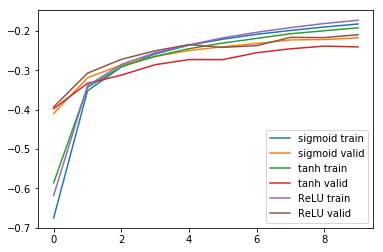

In [32]:
# Plot results for different activation functions

for name, delta in deltas.items():
    print("\nUSING DELTA =", name, "\n")
    log_p_train, log_p_valid, model = test_model(best_alpha, delta, num_hid, num_epochs, name)

plt.legend()
plt.show()

In [ ]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))